In [1]:
import mne
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explicação

Esse primeiro script deve preparar os dados brutos para o formato aceitável do segundo Script. No final, ele deve criar um arquivo com as seguintes características:
* Cada linha representa um registro de tempo
* O número de colunas deve ser o número de canais do EEG (ou qualquer outro sinal temporal) + 1 (coluna de saída)
* A coluna de saída deve se chamar 'Classe'

Esse script varia de problema para problema, dependendo das necessidades a serem cumpridas.

Obs: os 3 pontos listados acima é apenas para minimizar o trabalho do usuário, dado que o segundo script requer dados dessa forma. Qualquer mudança nesses pontos devem ser alterados no segundo script também!

In [2]:
# Essa primeira parte o usuário deve definir

run = 10
sub = 15
me = mne.io.read_raw_gdf(f"../DATA_RAW/motorexecution_subject{sub}_run{run}.gdf", stim_channel=-1)

Extracting EDF parameters from C:\Users\feammachado\Projects\TCC_Mortal\Dados Internet\DATA_RAW\motorexecution_subject15_run10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\users\feammachado\appdata\local\programs\python\python37\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-2-80d4c468934a>:5: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['ShoulderAdductio', 'ShoulderFlexionE', 'ShoulderRotation']
  me = mne.io.read_raw_gdf(f"../DATA_RAW/motorexecution_subject{sub}_run{run}.gdf", stim_channel=-1)


In [3]:
me_df = me.to_data_frame()
time = me_df[["time"]]
me_df = me_df.dropna().set_index("time")
index = me_df.index[(me_df == 0).sum(axis=1) < 20]
me_df = me_df.loc[index]
me_norm = (me_df - me_df.mean(axis=0))/me_df.std(axis=0)

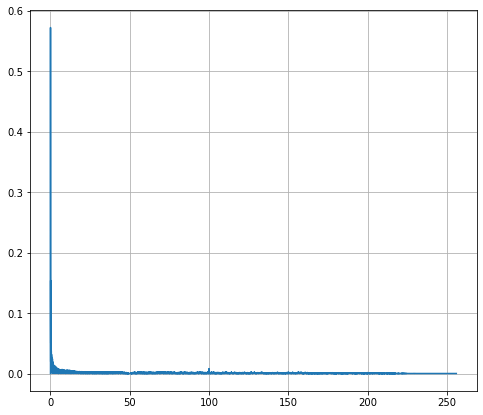

In [4]:
from scipy.fft import fft
from scipy.signal import resample
y = me_norm.values[:,0]
yf = fft(y)
fa = 512
T = 1/fa
N = y.size

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(8,7))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [5]:
time = time[time.time >= index[0]]

In [6]:
events, _ = mne.events_from_annotations(me)
t_col = events[events[:,2] == 1][:,0]
event_time = time.loc[t_col].values.flatten()
new_freq = 256

new_n = int(new_freq/fa*len(y))

new_time = index[0] + np.around(np.arange(new_n)*1000/new_freq)

new_df = pd.DataFrame([])

for i in range(61):
    col = f"Var_{i+1}"
    values = me_norm.values[:,i]
    new_df[col] = resample(values, new_n)
new_df.index = new_time

Used Annotations descriptions: ['1536', '1537', '1538', '1539', '1540', '1541', '1542', '33536', '33554', '34304', '34305', '34306', '34307', '34308', '34309', '34310', '768', '785', '786']


In [7]:
ant = 50
pos = 50

for i in range(len(event_time)):
    cond = (new_df.index <= event_time[i] + pos) & (new_df.index >= event_time[i] - ant)
    index_time = new_df.index[cond]
    new_df.loc[index_time, "Classe"] = 1
new_df.fillna(0, inplace=True)

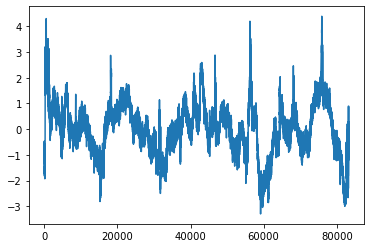

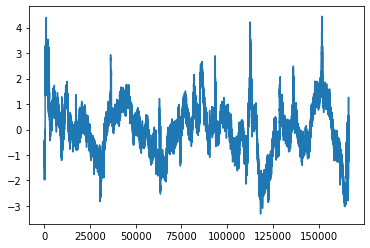

In [8]:
c = 3
plt.plot(np.arange(new_n), new_df.values[:,c])
plt.show()
plt.plot(np.arange(N), me_norm.values[:,c])
plt.show()

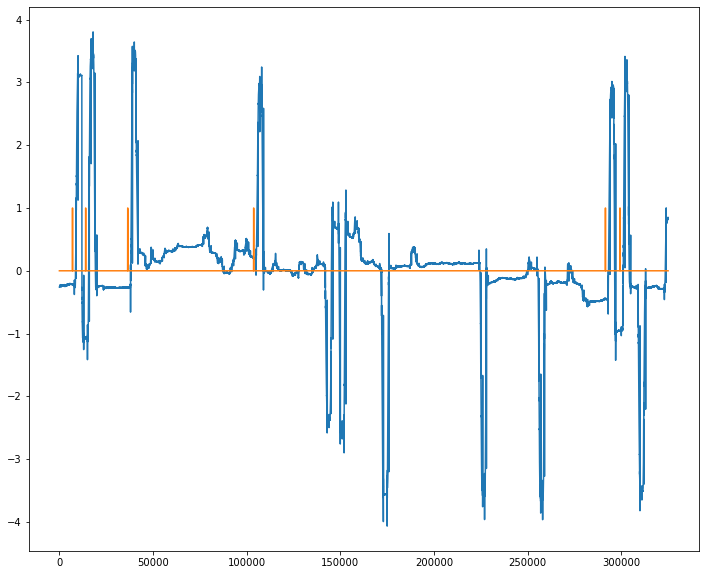

In [9]:
plt.figure(figsize=(12,10))
plt.plot(me_norm.index, me_norm.Elbow.values)
plt.plot(new_df.index, new_df.Classe.values)
plt.show()

In [10]:
if not os.path.isdir(f"../DATA_TIDY/subject {sub}"):
    os.mkdir(f"../DATA_TIDY/subject {sub}")

new_df.to_parquet(f"../DATA_TIDY/subject {sub}/data{sub}pp_{run}.parquet")

In [11]:

df_2 = pd.read_parquet(f"../DATA_TIDY/subject {sub}/signal_15_10.parquet")

In [13]:
df_2["Elbow"] = resample(me_norm.Elbow.values, new_n)[9:]

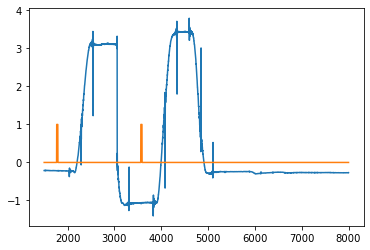

In [14]:
df_2.iloc[1500:8000].Elbow.plot()
df_2.iloc[1500:8000].y.plot()
plt.show()

In [15]:
df_2.iloc[1500:6500].to_parquet('data_test.parquet')